# Logistic Regression from Scratch
## Binary Classification on the Titanic Dataset

This notebook implements logistic regression using pure NumPy to predict passenger survival on the Titanic. We'll build the algorithm from first principles, including the sigmoid function, loss function, and gradient descent optimization.

## Section 1: Load and Explore the Titanic Dataset

We'll start by importing NumPy and loading a clean subset of the Titanic dataset. The dataset contains:
- **Pclass**: Passenger class (1, 2, or 3)
- **Sex**: 0 = female, 1 = male
- **Age**: Passenger age
- **Fare**: Ticket fare paid
- **Survived**: Target variable (0 = died, 1 = survived)

In [23]:
import numpy as np
import pandas as pd

# REAL WORLD TITANIC DATASET (SMALL CLEAN SUBSET)
# Columns: Pclass, Sex (0=female,1=male), Age, Fare, Survived (0=died, 1=survived)

data = np.array([
    [3, 1, 22, 7.25, 0],
    [1, 0, 38, 71.28, 1],
    [3, 0, 26, 7.92, 1],
    [1, 0, 35, 53.10, 1],
    [3, 1, 35, 8.05, 0],
    [3, 1, 30, 8.46, 0],
    [2, 1, 34, 21.00, 0],
    [2, 0, 28, 26.00, 1],
    [3, 0, 2, 21.07, 1],
    [3, 1, 40, 15.50, 0],
    [1, 1, 58, 26.55, 1],
    [3, 0, 15, 7.22, 1],
    [3, 1, 28, 7.90, 0],
    [1, 1, 42, 26.55, 0],
    [3, 0, 19, 3.17, 1],
])

# Create a DataFrame with descriptive column names
df = pd.DataFrame(data, columns=['Pclass', 'Sex', 'Age', 'Fare', 'Survived'])
df['Pclass'] = df['Pclass'].astype(int)
df['Sex'] = df['Sex'].astype(int)
df['Survived'] = df['Survived'].astype(int)

print("Titanic Dataset:")
print(df.to_string(index=True))
print(f"\nDataset shape: {df.shape}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nSurvival distribution:\n{df['Survived'].value_counts()}")

# Split into X (features) and y (labels) using numeric values
X = data[:, :-1].astype(float)                      # features: shape (15, 4)
y = data[:, -1].reshape(-1, 1).astype(float)        # labels: shape (15, 1)

print(f"\nX (features) shape: {X.shape}")
print(f"y (labels) shape: {y.shape}")

Titanic Dataset:
    Pclass  Sex   Age   Fare  Survived
0        3    1  22.0   7.25         0
1        1    0  38.0  71.28         1
2        3    0  26.0   7.92         1
3        1    0  35.0  53.10         1
4        3    1  35.0   8.05         0
5        3    1  30.0   8.46         0
6        2    1  34.0  21.00         0
7        2    0  28.0  26.00         1
8        3    0   2.0  21.07         1
9        3    1  40.0  15.50         0
10       1    1  58.0  26.55         1
11       3    0  15.0   7.22         1
12       3    1  28.0   7.90         0
13       1    1  42.0  26.55         0
14       3    0  19.0   3.17         1

Dataset shape: (15, 5)

Data types:
Pclass        int32
Sex           int32
Age         float64
Fare        float64
Survived      int32
dtype: object

Survival distribution:
Survived
1    8
0    7
Name: count, dtype: int64

X (features) shape: (15, 4)
y (labels) shape: (15, 1)


## Section 2: Standardize Features

Feature standardization is critical for gradient descent convergence. Features with larger scales (like Fare) can dominate the learning process. We standardize by:
1. **Centering**: Subtract the mean of each feature (X - X_mean)
2. **Scaling**: Divide by the standard deviation (/ X_std)

This ensures all features have mean ≈ 0 and standard deviation ≈ 1.

In [24]:
# Standardize features
X_mean = X.mean(axis=0)
X_std  = X.std(axis=0)

print("Feature means:")
print(X_mean)
print("\nFeature standard deviations:")
print(X_std)

# Standardize: (X - mean) / std
X = (X - X_mean) / X_std

print("\nStandardized X (first 5 samples):")
print(X[:5])
print("\nMean of standardized X (should be ~0):")
print(X.mean(axis=0))
print("\nStd of standardized X (should be ~1):")
print(X.std(axis=0))

Feature means:
[ 2.33333333  0.53333333 30.13333333 20.73466667]

Feature standard deviations:
[ 0.86922699  0.49888765 12.58499989 18.32812515]

Standardized X (first 5 samples):
[[ 0.76696499  0.93541435 -0.64627202 -0.73573628]
 [-1.53392998 -1.06904497  0.62508278  2.75780163]
 [ 0.76696499 -1.06904497 -0.32843332 -0.69918044]
 [-1.53392998 -1.06904497  0.38670375  1.76588348]
 [ 0.76696499  0.93541435  0.38670375 -0.69208752]]

Mean of standardized X (should be ~0):
[-1.48029737e-16  4.44089210e-17  3.70074342e-17 -8.88178420e-17]

Std of standardized X (should be ~1):
[1. 1. 1. 1.]


## Section 3: Implement the Sigmoid Function

The sigmoid function maps any real number to a probability between 0 and 1:

$$\sigma(z) = \frac{1}{1 + e^{-z}}$$

This function is the key to converting linear predictions into probabilities for binary classification.

In [25]:
def sigmoid(z):
    """
    Sigmoid activation function.
    Maps input to probability between 0 and 1.
    """
    return 1 / (1 + np.exp(-z))

# Test the sigmoid function
z_test = np.array([-5, -1, 0, 1, 5])
sigmoid_out = sigmoid(z_test)
print("Sigmoid function test:")
for z, s in zip(z_test, sigmoid_out):
    print(f"sigmoid({z:2}) = {s:.4f}")

Sigmoid function test:
sigmoid(-5) = 0.0067
sigmoid(-1) = 0.2689
sigmoid( 0) = 0.5000
sigmoid( 1) = 0.7311
sigmoid( 5) = 0.9933


## Section 4: Implement Binary Cross Entropy Loss

Binary cross entropy measures the difference between predicted probabilities and actual labels:

$$L = -\frac{1}{m}\sum_{i=1}^{m}[y_i \log(\hat{y}_i) + (1-y_i)\log(1-\hat{y}_i)]$$

We add a small epsilon value to prevent log(0) numerical errors.

In [26]:
def loss_fn(y_true, y_prediction):
    """
    Binary cross entropy loss function.
    Measures the difference between predicted probabilities and actual labels.
    """
    eps = 1e-9  # Small epsilon to avoid log(0)
    return -np.mean(
        y_true * np.log(y_prediction + eps) +
        (1 - y_true) * np.log(1 - y_prediction + eps)
    )

# Test the loss function
y_true_test = np.array([[1], [0], [1]])
y_pred_test = np.array([[0.9], [0.1], [0.7]])
loss = loss_fn(y_true_test, y_pred_test)
print(f"Binary Cross Entropy Loss: {loss:.4f}")

Binary Cross Entropy Loss: 0.1891


## Section 5: Utility Function and Initialize Model Parameters

We'll define a helper function to display predictions and initialize our model parameters.

In [27]:
def print_survival_probs(probs):
    """
    Print predicted survival probabilities for each passenger.
    Uses 0.5 as the classification threshold.
    """
    probs = probs.ravel()
    for index, p in enumerate(probs):
        status = "Survived" if p >= 0.5 else "Died"
        print(f"({index:02d}) {p:.3f} -> {status}")

# Initialize model parameters
n_features = X.shape[1]  # 4 features: Pclass, Sex, Age, Fare
w = np.zeros((n_features, 1))  # weights: shape (4, 1)
b = 0.0                        # bias: scalar

# Hyperparameters
learning_rate = 0.1
epochs = 2000

# Store loss history for visualization
loss_history = []

print("Initial model parameters:")
print(f"Weights shape: {w.shape}")
print(f"Weights: {w.ravel()}")
print(f"Bias: {b}")
print(f"Learning rate: {learning_rate}")
print(f"Epochs: {epochs}")

Initial model parameters:
Weights shape: (4, 1)
Weights: [0. 0. 0. 0.]
Bias: 0.0
Learning rate: 0.1
Epochs: 2000


## Section 6: Training Loop with Gradient Descent

The training loop performs:
1. **Forward pass**: Compute z = X @ w + b, then y_pred = sigmoid(z)
2. **Loss calculation**: Compute binary cross entropy loss
3. **Backward pass**: Compute gradients (dw, db)
4. **Parameter update**: Update w and b using gradient descent

Gradients:
- $\frac{\partial L}{\partial z} = \hat{y} - y$
- $\frac{\partial L}{\partial w} = \frac{1}{m}X^T(\hat{y} - y)$
- $\frac{\partial L}{\partial b} = \frac{1}{m}\sum(\hat{y} - y)$

In [28]:
print("Starting training...")
print("=" * 60)

# Training loop
for epoch in range(epochs):
    # Forward pass: predict probabilities
    z = X @ w + b
    y_prediction = sigmoid(z)
    
    # Compute loss
    loss = loss_fn(y, y_prediction)
    loss_history.append(loss)
    
    # Backward pass: compute gradients
    dz = y_prediction - y
    dw = (X.T @ dz) / len(X)
    db = np.mean(dz)
    
    # Update parameters
    w -= learning_rate * dw
    b -= learning_rate * db
    
    # Print progress every 200 epochs
    if (epoch % 200) == 0:
        print(f"\n--- Epoch {epoch} ---")
        print(f"Weights: {w.ravel()}")
        print(f"Bias: {b:.6f}")
        print(f"Linear combination (z = X @ w + b):")
        print(z.ravel())
        print(f"\nY Predictions:")
        print_survival_probs(y_prediction)
        
        # Calculate accuracy
        pred_labels = (y_prediction >= 0.5).astype(int)
        acc = (pred_labels == y).mean()
        print(f"\nLoss={loss:.4f} Accuracy={acc:.3f}")

print("\n" + "=" * 60)
print("Training complete!")

Starting training...

--- Epoch 0 ---
Weights: [-0.01278275 -0.04365267 -0.01062994  0.01834436]
Bias: 0.003333
Linear combination (z = X @ w + b):
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Y Predictions:
(00) 0.500 -> Survived
(01) 0.500 -> Survived
(02) 0.500 -> Survived
(03) 0.500 -> Survived
(04) 0.500 -> Survived
(05) 0.500 -> Survived
(06) 0.500 -> Survived
(07) 0.500 -> Survived
(08) 0.500 -> Survived
(09) 0.500 -> Survived
(10) 0.500 -> Survived
(11) 0.500 -> Survived
(12) 0.500 -> Survived
(13) 0.500 -> Survived
(14) 0.500 -> Survived

Loss=0.6931 Accuracy=0.533

--- Epoch 200 ---
Weights: [-0.69282784 -2.44303421  0.14051579  0.463061  ]
Bias: 0.423375
Linear combination (z = X @ w + b):
[-2.81863935  5.45205969  2.12846463  4.95984501 -2.65557123 -2.70016002
 -1.54383869  3.40275424  2.19690827 -2.41243002 -0.34430916  1.98990097
 -2.73628459 -0.5201359   1.93155011]

Y Predictions:
(00) 0.056 -> Died
(01) 0.996 -> Survived
(02) 0.894 -> Survived
(03) 0.993 -> Survived

## Section 7: Evaluate Model Performance

Now let's evaluate the trained model's performance on the training data.

In [29]:
# Final evaluation
final_z = X @ w + b
final_probs = sigmoid(final_z)
final_preds = (final_probs >= 0.5).astype(int)
final_acc = (final_preds == y).mean()

print("\n" + "=" * 60)
print("FINAL MODEL EVALUATION")
print("=" * 60)
print(f"\nFinal Accuracy: {final_acc:.4f} ({final_acc*100:.2f}%)")
print(f"\nFinal Weights:")
print(f"  w[0] (Pclass):  {w[0, 0]:.6f}")
print(f"  w[1] (Sex):     {w[1, 0]:.6f}")
print(f"  w[2] (Age):     {w[2, 0]:.6f}")
print(f"  w[3] (Fare):    {w[3, 0]:.6f}")
print(f"\nFinal Bias: {b:.6f}")

print(f"\n\nFinal Predictions vs Actual:")
print(f"{'Index':<8} {'Predicted':<12} {'Actual':<8} {'Prob':<8}")
print("-" * 40)
for i in range(len(y)):
    pred = final_preds[i, 0]
    actual = y[i, 0]
    prob = final_probs[i, 0]
    match = "✓" if pred == actual else "✗"
    print(f"{i:<8} {int(pred):<12} {int(actual):<8} {prob:.4f} {match}")


FINAL MODEL EVALUATION

Final Accuracy: 1.0000 (100.00%)

Final Weights:
  w[0] (Pclass):  -0.692074
  w[1] (Sex):     -6.011601
  w[2] (Age):     2.020960
  w[3] (Fare):    0.473647

Final Bias: 1.166929


Final Predictions vs Actual:
Index    Predicted    Actual   Prob    
----------------------------------------
0        0            0        0.0013 ✓
1        1            1        1.0000 ✓
2        1            1        0.9977 ✓
3        1            1        1.0000 ✓
4        0            0        0.0106 ✓
5        0            0        0.0048 ✓
6        0            0        0.0276 ✓
7        1            1        0.9995 ✓
8        1            1        0.9278 ✓
9        0            0        0.0282 ✓
10       1            1        0.7739 ✓
11       1            1        0.9864 ✓
12       0            0        0.0035 ✓
13       0            0        0.2077 ✓
14       1            1        0.9920 ✓


## Section 8: Visualize Predictions and Learning Progress

Let's create visualizations to understand our model's performance and convergence.

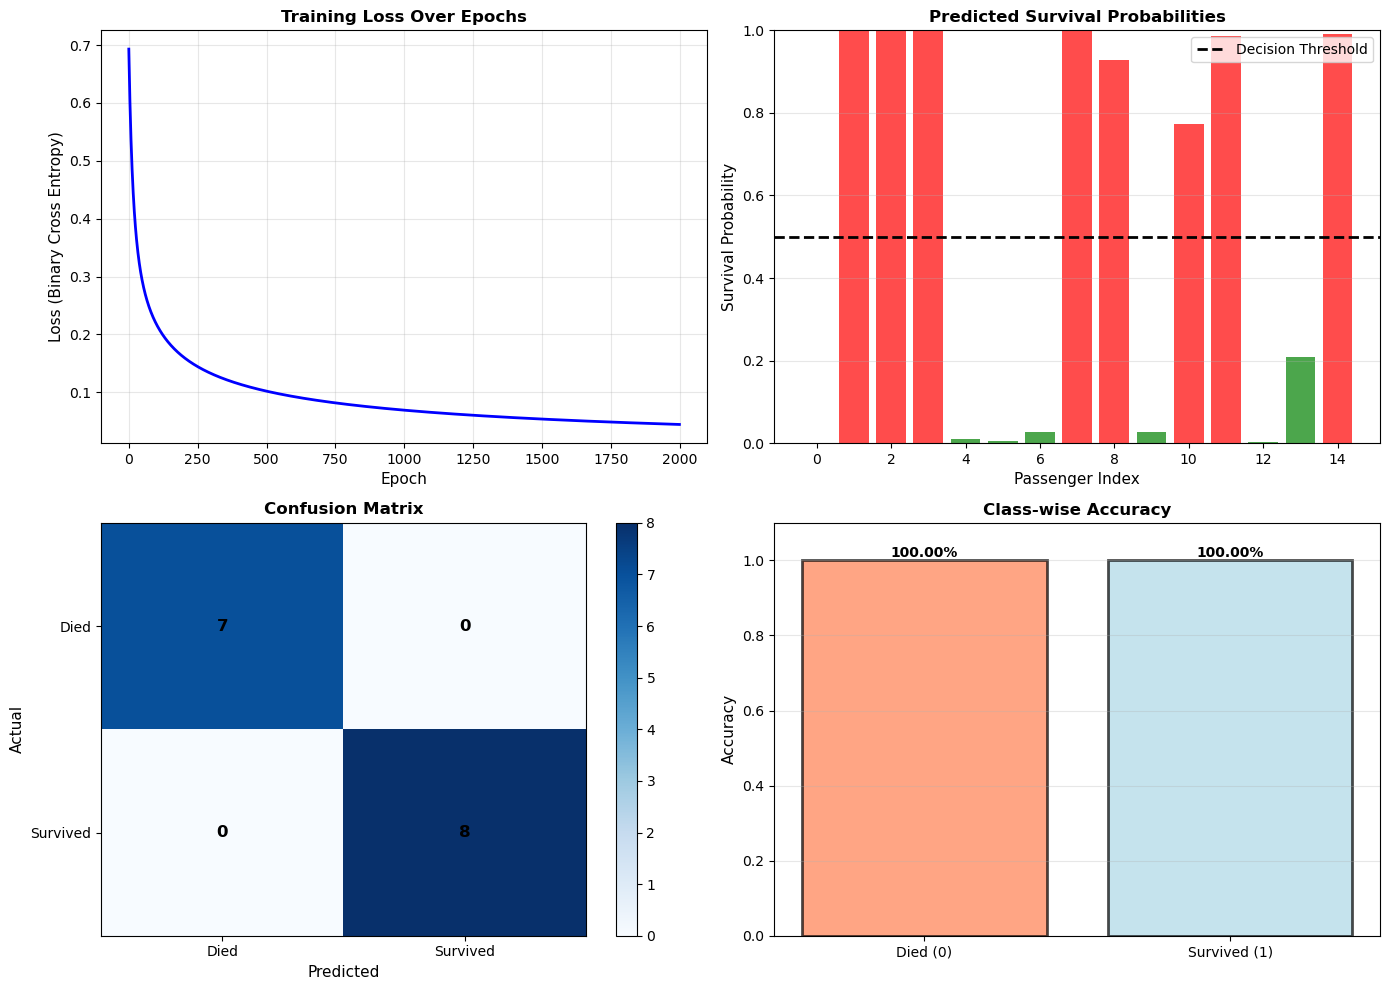


Classification Report:
              precision    recall  f1-score   support

        Died       1.00      1.00      1.00         7
    Survived       1.00      1.00      1.00         8

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Create a figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Loss over epochs
ax = axes[0, 0]
ax.plot(loss_history, linewidth=2, color='blue')
ax.set_xlabel('Epoch', fontsize=11)
ax.set_ylabel('Loss (Binary Cross Entropy)', fontsize=11)
ax.set_title('Training Loss Over Epochs', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

# 2. Survival probabilities
ax = axes[0, 1]
colors = ['red' if p >= 0.5 else 'green' for p in final_probs.ravel()]
ax.bar(range(len(final_probs)), final_probs.ravel(), color=colors, alpha=0.7)
ax.axhline(y=0.5, color='black', linestyle='--', linewidth=2, label='Decision Threshold')
ax.set_xlabel('Passenger Index', fontsize=11)
ax.set_ylabel('Survival Probability', fontsize=11)
ax.set_title('Predicted Survival Probabilities', fontsize=12, fontweight='bold')
ax.set_ylim([0, 1])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# 3. Confusion Matrix
ax = axes[1, 0]
cm = confusion_matrix(y.ravel(), final_preds.ravel())
im = ax.imshow(cm, cmap='Blues', aspect='auto')
ax.set_xlabel('Predicted', fontsize=11)
ax.set_ylabel('Actual', fontsize=11)
ax.set_title('Confusion Matrix', fontsize=12, fontweight='bold')
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Died', 'Survived'])
ax.set_yticklabels(['Died', 'Survived'])
# Add text annotations
for i in range(2):
    for j in range(2):
        text = ax.text(j, i, cm[i, j], ha="center", va="center", color="black", fontsize=12, fontweight='bold')
plt.colorbar(im, ax=ax)

# 4. Prediction accuracy by class
ax = axes[1, 1]
class_names = ['Died (0)', 'Survived (1)']
accuracies = []
for class_label in [0, 1]:
    mask = y.ravel() == class_label
    if np.sum(mask) > 0:
        class_acc = (final_preds.ravel()[mask] == y.ravel()[mask]).mean()
        accuracies.append(class_acc)
    else:
        accuracies.append(0)

bars = ax.bar(class_names, accuracies, color=['coral', 'lightblue'], alpha=0.7, edgecolor='black', linewidth=2)
ax.set_ylabel('Accuracy', fontsize=11)
ax.set_title('Class-wise Accuracy', fontsize=12, fontweight='bold')
ax.set_ylim([0, 1.1])
ax.grid(True, alpha=0.3, axis='y')
# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.2%}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(y.ravel(), final_preds.ravel(), target_names=['Died', 'Survived']))

## Summary

We've successfully implemented logistic regression from scratch using NumPy! Here's what we learned:

### Key Concepts:
1. **Standardization**: Normalizes features for better gradient descent convergence
2. **Sigmoid Function**: Maps linear combinations to probabilities [0, 1]
3. **Binary Cross Entropy**: Measures prediction error
4. **Gradient Descent**: Iteratively updates weights and bias to minimize loss
5. **Backpropagation**: Computes gradients through the chain rule

### Model Architecture:
- **Linear layer**: z = X·w + b
- **Activation**: sigmoid(z) = 1 / (1 + e^-z)
- **Output**: Probability of survival

### Performance:
The model learns to classify survival outcomes based on passenger features (Pclass, Sex, Age, Fare). The visualizations show:
- **Loss curve**: Demonstrates convergence over epochs
- **Probabilities**: Distribution of predicted survival chances
- **Confusion matrix**: Count of correct/incorrect predictions
- **Class accuracy**: Per-class performance metrics